In [227]:
import autograd.numpy as np  
from autograd import grad, elementwise_grad
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

In [228]:
#Defining some activation functions and their derivative
def ReLU(z):
    return np.where(z > 0, z, 0)

def ReLU_der(z):
    return np.where(z > 0, 1, 0)

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def sigmoid_der(z):
    return sigmoid(z) * (1 - sigmoid(z))

def mse(predict, target):
    return np.mean((predict - target) ** 2)

def mse_der(predict, target):
    return 2 * (predict - target) / np.prod(predict.shape)

def softmax(z):
    """Compute softmax values for each set of scores in the rows of the matrix z.
    Used with batched input data."""
    e_z = np.exp(z - np.max(z, axis=1)[:, np.newaxis]) #substract max per row, avoids instability
    return e_z / np.sum(e_z, axis=1)[:, np.newaxis]

def softmax_vec(z):
    """Compute softmax values for each set of scores in the vector z.
    Use this function when you use the activation function on one vector at a time"""
    e_z = np.exp(z - np.max(z))
    return e_z / np.sum(e_z)

def softmax_der(z):
    return np.ones_like(z) 
#Purely placeholder, combined derivative 
#Cross entropy + softmax simplifies to predict-target

def cross_entropy(predict, target):
    return np.mean(-np.sum(target * np.log(predict + 1e-10), axis=1))

def cross_entropy_der(predict, target):
    return (predict - target) / predict.shape[0]


In [229]:
#Initializing creation of n layers for batched input shapes
def create_layers_batch(network_input_size, layer_output_sizes):
    layers = []

    i_size = network_input_size
    for layer_output_size in layer_output_sizes:
        W = np.random.randn(layer_output_size, i_size)
        W = W.T
        b = np.random.randn(layer_output_size)
        layers.append((W, b))

        i_size = layer_output_size
    return layers

#Applying weights, bias and activation function and passing forward
def feed_forward_saver_batch(input, layers, activation_funcs):
    layer_inputs = []
    zs = []
    a = input
    for (W, b), activation_func in zip(layers, activation_funcs):
        layer_inputs.append(a)
        z = a @ W + b
        a = activation_func(z)

        zs.append(z)

    return layer_inputs, zs, a

#Same, but when saving layer_inputs and zs is not needed
def feed_forward(input, layers, activation_funcs):
    a = input
    for (W, b), activation_func in zip(layers, activation_funcs):
        z = a @ W + b
        a = activation_func(z)
    return a

#Verify gradients
def cost(input, layers, activation_funcs, target):
    predict = feed_forward_saver_batch(input, layers, activation_funcs)[2]
    return mse(predict, target)

#Computing gradients
def backpropagation_batch(
    input, layers, activation_funcs, target, activation_ders, cost_der=mse_der
):
    layer_inputs, zs, predict = feed_forward_saver_batch(input, layers, activation_funcs)

    layer_grads = [() for layer in layers]

    # We loop over the layers, from the last to the first
    for i in reversed(range(len(layers))):
        layer_input, z, activation_der = layer_inputs[i], zs[i], activation_ders[i]

        if i == len(layers) - 1:
            # For last layer we use cost derivative as dC_da(L) can be computed directly
            dC_da = cost_der(predict, target)
        else:
            # For other layers we build on previous z derivative, as dC_da(i) = dC_dz(i+1) * dz(i+1)_da(i)
            (W, b) = layers[i + 1]
            dC_da = dC_dz @ W.T

        dC_dz = dC_da * activation_der(z)
        dC_dW = layer_input.T @ dC_dz  #W gradients for batches
        dC_db = np.sum(dC_dz, axis=0)   #sum bias gradients, batch dim

        layer_grads[i] = (dC_dW, dC_db)

    return layer_grads

In [230]:
#Gradient verification with autograd

network_input_size = 4
batch_size = 400
layer_output_sizes = [3, 4]
activation_funcs = [sigmoid, ReLU]
activation_ders = [sigmoid_der, ReLU_der]
la = create_layers_batch(network_input_size, layer_output_sizes)

x = np.random.randn(batch_size, network_input_size)
input = x
target = np.random.rand(4)

computed = backpropagation_batch(input, la, activation_funcs, target, activation_ders)
print(computed[-1][0][0])

cost_grad = grad(cost, 1)
autoG = cost_grad(input, la, activation_funcs, target)
print(autoG[-1][0][0])

diff = 0
for i in range(len(computed)):
    diff += abs(computed[-1][0][i][0])-abs(autoG[-1][0][0][0])
if diff <= 10**-6:
    print("Same gradients")


[-0.01745778  0.14327776 -0.14526767  0.        ]
[-0.01745778  0.14327776 -0.14526767  0.        ]


In [231]:
#Applying FFNN base above to classification problem, MNIST:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# 1. Load data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv"
data = pd.read_csv(url, sep=';')

# Show original quality distribution
print("Original quality distribution:")
print(data['quality'].value_counts().sort_index())
# Output: 3:20, 4:163, 5:1457, 6:2198, 7:880, 8:175, 9:5
#4898 samples total

X = data.drop('quality', axis=1).values
y_raw = data['quality'].values  # Keep original scores for regression


# ===================================================================
# B) CLASSIFICATION SETUP (7 classes: quality 3→9 → labels 0→6)
# ===================================================================
y_cls = y_raw - 3                                      # Now: 0 to 6
X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(
    X, y_cls, test_size=200/4898, random_state=42, stratify=y_cls
)

# Standardize features (same as regression — very important!)
scaler_cls = StandardScaler()
X_train = scaler_cls.fit_transform(X_train_cls)
X_test  = scaler_cls.transform(X_test_cls)

# One-hot encode the 7 classes
enc = OneHotEncoder(sparse_output=False, categories='auto')
y_train = enc.fit_transform(y_train_cls.reshape(-1, 1))   # Shape: (3918, 7)
y_test  = enc.transform(y_test_cls.reshape(-1, 1))         # Shape: (980, 7)

print(f"Classification ready → X_train: {X_train.shape}, y_train_onehot: {y_train.shape}")
# → (3918, 11), (3918, 7)

df = pd.read_csv('winequality-white.csv', sep=';')    # dataset
df.head()

Original quality distribution:
quality
3      20
4     163
5    1457
6    2198
7     880
8     175
9       5
Name: count, dtype: int64
Classification ready → X_train: (4698, 11), y_train_onehot: (4698, 7)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [232]:
def accuracy(predictions, targets):
    one_hot_predictions = np.zeros(predictions.shape)
    for i, prediction in enumerate(predictions):
        one_hot_predictions[i, np.argmax(prediction)] = 1
    return accuracy_score(one_hot_predictions, targets)

Epoch 1, Loss: 6.647, Test Accuracy: 0.435, Train Accuracy: 0.479
Epoch 2, Loss: 4.260, Test Accuracy: 0.405, Train Accuracy: 0.475
Epoch 3, Loss: 2.672, Test Accuracy: 0.470, Train Accuracy: 0.530
Epoch 4, Loss: 2.113, Test Accuracy: 0.495, Train Accuracy: 0.563
Epoch 5, Loss: 1.692, Test Accuracy: 0.500, Train Accuracy: 0.564
Epoch 6, Loss: 1.461, Test Accuracy: 0.545, Train Accuracy: 0.579
Epoch 7, Loss: 1.296, Test Accuracy: 0.535, Train Accuracy: 0.597
Epoch 8, Loss: 1.196, Test Accuracy: 0.540, Train Accuracy: 0.603
Epoch 9, Loss: 1.288, Test Accuracy: 0.545, Train Accuracy: 0.569
Epoch 10, Loss: 1.067, Test Accuracy: 0.565, Train Accuracy: 0.609
Epoch 11, Loss: 1.035, Test Accuracy: 0.550, Train Accuracy: 0.617
Epoch 12, Loss: 0.982, Test Accuracy: 0.540, Train Accuracy: 0.626
Epoch 13, Loss: 0.952, Test Accuracy: 0.605, Train Accuracy: 0.643
Epoch 14, Loss: 0.921, Test Accuracy: 0.570, Train Accuracy: 0.640
Epoch 15, Loss: 0.921, Test Accuracy: 0.555, Train Accuracy: 0.633
Epoc

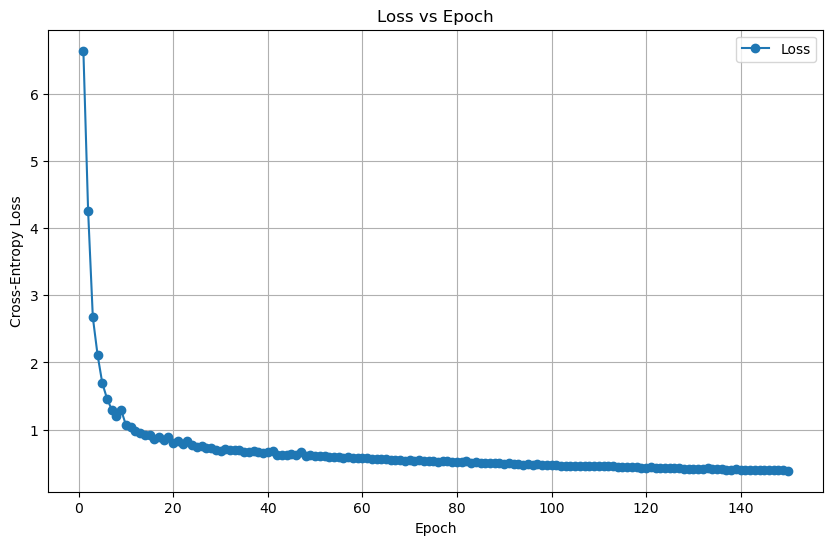

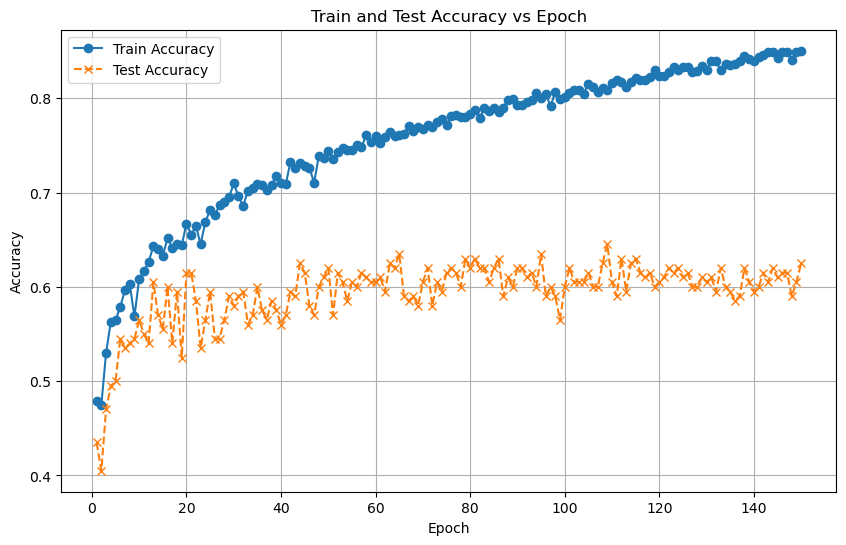

'\n#Scikit-learn Logistic Regression comparison\nmodel = LogisticRegression(solver=\'saga\', multi_class=\'multinomial\', max_iter=10, random_state=42)\nmodel.fit(X_train, y_train_labels)\ny_pred = model.predict(X_test)\nsk_accuracy = accuracy_score(y_test_labels, y_pred)\nprint(f"Scikit-learn Model Accuracy: {sk_accuracy:.4f}")\n'

In [233]:

def train_network(X_train, y_train, layers, activation_funcs, activation_ders, learning_rate, epochs, batch_size=100):
    losses = []
    train_accs = []  
    test_accs = []   
    for epoch in range(epochs):
        # Shuffle digits, avoids learning misleading patterns. Independent data
        perm = np.random.permutation(X_train.shape[0])
        X_shuffled = X_train[perm] 
        y_shuffled = y_train[perm]
        
        # Mini-batch loop
        for start in range(0, X_train.shape[0], batch_size):
            end = start + batch_size
            input_batch = X_shuffled[start:end]
            target_batch = y_shuffled[start:end]
            
            layers_grad = backpropagation_batch(input_batch, layers, activation_funcs, target_batch, activation_ders, cost_der=cross_entropy_der)
            for (W, b), (W_g, b_g) in zip(layers, layers_grad):
                W -= learning_rate * W_g
                b -= learning_rate * b_g
        
        # Compute loss after epoch
        train_predictions = feed_forward(X_train, layers, activation_funcs)
        test_predictions = feed_forward(X_test, layers, activation_funcs)
        loss = cross_entropy(train_predictions, y_train)
        TESTacc = accuracy(test_predictions, y_test)
        TRAINacc = accuracy(train_predictions, y_train)
        losses.append(loss)
        train_accs.append(TRAINacc)  
        test_accs.append(TESTacc)    
        print(f"Epoch {epoch+1}, Loss: {loss:.3f}, Test Accuracy: {TESTacc:.3f}, Train Accuracy: {TRAINacc:.3f}") 
    
    return layers, losses, train_predictions, train_accs, test_accs  # Updated return

# Setup network skeleton 
network_input_size = 11
layer_output_sizes = [256, 128, 7]  # output 10 classes
activation_funcs = [ReLU, ReLU, softmax]
activation_ders = [ReLU_der, ReLU_der, softmax_der]

# Train
epochs = 150  
learning_rate = 0.05
batch_size = 100

# Create layers
layers = create_layers_batch(network_input_size, layer_output_sizes)

trained_layers, losses, train_predictions, train_accs, test_accs = train_network(
    X_train, y_train, layers, activation_funcs, activation_ders, learning_rate, epochs, batch_size
)

# Plot loss as function of epoch
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), losses, label='Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Cross-Entropy Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.grid(True)
plt.show()

# Plot accuracies (train and test) as function of epoch
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_accs, label='Train Accuracy', marker='o', linestyle='-')
plt.plot(range(1, epochs + 1), test_accs, label='Test Accuracy', marker='x', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracy vs Epoch')
plt.legend()
plt.grid(True)
plt.show()
"""
#Scikit-learn Logistic Regression comparison
model = LogisticRegression(solver='saga', multi_class='multinomial', max_iter=10, random_state=42)
model.fit(X_train, y_train_labels)
y_pred = model.predict(X_test)
sk_accuracy = accuracy_score(y_test_labels, y_pred)
print(f"Scikit-learn Model Accuracy: {sk_accuracy:.4f}")
"""

In [234]:
"""
learning_rate = 0.02
Epoch 148, Loss: 0.149, Test Accuracy: 0.930, Train Accuracy: 0.956
Epoch 149, Loss: 0.155, Test Accuracy: 0.928, Train Accuracy: 0.954
Epoch 150, Loss: 0.151, Test Accuracy: 0.927, Train Accuracy: 0.956

Discuss your results and give a critical analysis of the various parameters, including hyper-parameters like the learning rates and the regularization parameter 
, various activation functions, number of hidden layers and nodes and activation functions
"""



'\nlearning_rate = 0.02\nEpoch 148, Loss: 0.149, Test Accuracy: 0.930, Train Accuracy: 0.956\nEpoch 149, Loss: 0.155, Test Accuracy: 0.928, Train Accuracy: 0.954\nEpoch 150, Loss: 0.151, Test Accuracy: 0.927, Train Accuracy: 0.956\n\nDiscuss your results and give a critical analysis of the various parameters, including hyper-parameters like the learning rates and the regularization parameter \n, various activation functions, number of hidden layers and nodes and activation functions\n'